# Общая информация о данных:

<b>wiki_arbcom.xlsx:</b>
- voter - ник голосовавшего юзера
- can_vote - считался ли его голос действующим
- time - когда был отдан голос
- candidate - ник кандидата
- n - порядковый номер выборов
- vote - голос за (1) или против (-1)

<b>wiki_userstat.xlsx</b>:
- User - ник юзера
- Groups - закодированные дополнительные права участника; <b>пустое значение</b> - нет дополнительных прав:
* S (sysop) - администратор - может блокировать юзеров и IP
- B (buerocrat) - бюрократ - может выдавать права администратора и другие
- С (checkuser) - чекьюзер - может проверять IP участников
- O (supress) - ревизор - может скрывать информацию
- I (IPblock-exempt) - исключение из IP блокировок - может править из-под заблокированного IP
- EditsTotal — все правки
- EditsEdits — не удалённые
- EditsArticles — правки в энциклопедических статьях
- CreationsPages — количество любых созданных страниц
- CreationsArticles — количество созданных энциклопедических страниц
- TextsVolume — объём добавленного текста (байты)
- Logs — количество записей в логах о действиях, не являющихся правками
- Months — количество месяцев участия
- H/d — среднее время участия в день

# Импорт библиотек. Загрузка

In [624]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 

from sklearn.cluster import KMeans

In [267]:
wiki_arbcom = pd.read_excel('wiki_arbcom.xlsx', index_col=0) 

In [268]:
wiki_stat_full = pd.read_excel('wiki_stat_full.xlsx', index_col=0) 

# wiki_arbcom

In [269]:
wiki_arbcom.head(5)

,voter,can_vote,time,candidate,n,vote
0,X0stark69,True,2020-07-30 11:55:00,Adamant.pwn,30,1
1,Mike like0708,True,2020-07-30 09:32:00,Adamant.pwn,30,-1
2,Brateevsky,True,2020-07-30 14:43:00,Adamant.pwn,30,1
3,Forgottenous,True,2020-07-30 08:09:00,Adamant.pwn,30,1
4,Swarrel,True,2020-08-02 14:57:00,Adamant.pwn,30,1


In [270]:
wiki_arbcom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16857 entries, 0 to 2738
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   voter      16857 non-null  object        
 1   can_vote   16857 non-null  bool          
 2   time       16857 non-null  datetime64[ns]
 3   candidate  16857 non-null  object        
 4   n          16857 non-null  int64         
 5   vote       16857 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(2)
memory usage: 806.6+ KB


In [271]:
print(wiki_arbcom.duplicated().sum())
wiki_arbcom = wiki_arbcom.drop_duplicates()

0


In [471]:
print('общая инфоромация о голосовании:')
for i in sorted(list(set(wiki_arbcom['n']))):
    print('n:', i, '  count:', wiki_arbcom['n'][wiki_arbcom['n']==i].count(),
          '  start:', wiki_arbcom['time'][wiki_arbcom['n']==i].min(),
          '  stop:', wiki_arbcom['time'][wiki_arbcom['n']==i].max())

общая инфоромация о голосовании:
n: 30   count: 2041   start: 2020-07-30 00:02:00   stop: 2020-08-05 23:10:00
n: 31   count: 2041   start: 2020-07-30 00:02:00   stop: 2020-08-05 23:10:00
n: 32   count: 4170   start: 2021-07-30 00:02:00   stop: 2021-08-05 23:59:00
n: 33   count: 3374   start: 2022-01-30 00:00:00   stop: 2022-02-05 23:59:00
n: 34   count: 3303   start: 2022-07-30 00:00:00   stop: 2022-08-05 23:59:00
n: 35   count: 1928   start: 2023-01-30 00:03:00   stop: 2023-02-06 04:18:00


В датасете wiki_arbcom 16857 строк, 6 колонок.

Пустых значений - нет. Явных дубликатов - нет.

Мы располагаем данными о 6 выборах (<s>не по-русски</s>), выборы № 30 и 31 - совпадает время начала и окончания. 

In [273]:
# всего приняло участие в голосовании по турам
# из них "can_vote" - пользователи, чей голос считался действующим

pd.DataFrame(wiki_arbcom['n'].value_counts()).reset_index().merge(
    pd.DataFrame(wiki_arbcom[wiki_arbcom['can_vote']==True]['n'].value_counts()).reset_index(), how='left', on='index') \
    .rename(columns={'index': 'n', 'n_x': 'all_voters', 'n_y': 'can_vote'})

,n,all_voters,can_vote
0,32,4170,4094
1,33,3374,3283
2,34,3303,3123
3,30,2041,1879
4,31,2041,1879
5,35,1928,1858


In [274]:
print('количество уникальных кандидатов в списке: ', wiki_arbcom['candidate'].nunique())

количество уникальных кандидатов в списке:  58


In [275]:
wiki_arbcom['candidate_n'] = wiki_arbcom['candidate'] + '_' + wiki_arbcom['n'].astype('str')

In [276]:
list_unique_candidate = [i[0] for i in [i.split('_') for i in list(set(wiki_arbcom.candidate_n))]]

In [277]:
count_candidate = {i: list_unique_candidate.count(i) for i in list_unique_candidate}

In [278]:
pd.DataFrame.from_dict(count_candidate, orient='index').reset_index() \
            .rename(columns={'index': 'candidate', 0: 'count'}) \
            .sort_values('count', ascending=False).head(10)

,candidate,count
37,Carn,5
23,Arsenal.UC,5
34,Alexander Roumega,5
1,Adamant.pwn,4
38,Uchastnik1,3
22,SerSem,3
14,Excellence,3
8,Venzz,3
20,Colt browning,3
25,Biathlon,2


В выборах принимало участие 58 кандидатов, из них рекордсмены (Arsenal.UC, Alexander Roumega, Carn) приняли участие в пяти выборах и шести.

In [279]:
print('количество уникальных пользователей: ', wiki_arbcom['voter'].nunique())

количество уникальных пользователей:  676


In [280]:
# посмотреть на то, как пользователи отдавали голоса:

# pd.crosstab(wiki_arbcom['voter'], wiki_arbcom['candidate'], values=wiki_arbcom['vote'], aggfunc='sum').fillna(0)

In [518]:
# сгруппируем оценки по пользователям, разделим оценки на "-1" и "1"
# подсчитаем, сколько всего оценок поставил каждый пользователь

votes_per_voters = pd.DataFrame(pd.crosstab(wiki_arbcom['voter'], wiki_arbcom['vote'], values=wiki_arbcom['vote'], 
                                 aggfunc='count')).reset_index().fillna(0)

votes_per_voters.rename(columns={-1: 'vote: -1', 1: 'vote: 1'}, inplace=True)

votes_per_voters['votes_sum'] = votes_per_voters.sum(axis=1)

votes_per_voters.head(3)

vote,voter,vote: -1,vote: 1,votes_sum
0,-PhoeniX-,5.0,9.0,14.0
1,1.b2-b4,8.0,3.0,11.0
2,1677venzel gottorpskij,1.0,2.0,3.0


In [519]:
# посмотрим статистику и
# найдем самых активноголосующих пользователей

votes_per_voters['votes_sum'].describe()

count    676.000000
mean      24.936391
std       22.154684
min        1.000000
25%       10.000000
50%       17.000000
75%       34.000000
max       99.000000
Name: votes_sum, dtype: float64

In [521]:
print('суммарное количество выставленных оценок - 95 перцентиль:', np.percentile(votes_per_voters['votes_sum'], 95))
print('суммарное количество выставленных оценок - 99 перцентиль:', np.percentile(votes_per_voters['votes_sum'], 99))
print('самых активных пользователей:', len(votes_per_voters[votes_per_voters['votes_sum'] >
                                                            np.percentile(votes_per_voters['votes_sum'], 95)]))

суммарное количество выставленных оценок - 95 перцентиль: 73.0
суммарное количество выставленных оценок - 99 перцентиль: 97.5
самых активных пользователей: 30


In [515]:
# посмотреть подробнее на активноголосующих пользователей:

# votes_per_voters[votes_per_voters['votes_sum'] > 73].sort_values('votes_sum', ascending=False)

В голосовании приняли участие 676 пользователей. Медианное значение количества выставленных оценок - 17, 30 пользователей выставило 73 и более оценок за шесть туров голосования.

# wiki_stat_full

In [285]:
wiki_stat_full.columns = [i.lower() for i in wiki_stat_full.columns]

In [286]:
wiki_stat_full.head(5)

,user,groups,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,h/d
0,MarchHare1977,NaN,670625,658747,229189,423066,18263,79000000,11878,49,8 h 15
1,Q-bit array,COS,568443,278128,119067,62470,40,203000000,290315,103,4 h 25
2,Valdis72,NaN,461773,268027,226018,36916,12295,116000000,193746,124,6 h 50
3,Tempus,NaN,372796,339636,269363,29679,922,141000000,33160,173,3 h 40
4,Simba16,NaN,370125,333356,277881,29413,5020,67000000,36769,135,3 h 05


In [287]:
wiki_stat_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2828 entries, 0 to 2827
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user               2828 non-null   object
 1   groups             73 non-null     object
 2   editstotal         2828 non-null   int64 
 3   editsedits         2828 non-null   int64 
 4   editsarticles      2828 non-null   int64 
 5   creationspages     2828 non-null   int64 
 6   creationsarticles  2828 non-null   int64 
 7   textsvolume        2828 non-null   int64 
 8   logs               2828 non-null   int64 
 9   months             2828 non-null   int64 
 10  h/d                2828 non-null   object
dtypes: int64(8), object(3)
memory usage: 265.1+ KB


In [288]:
print(wiki_stat_full.duplicated().sum())
wiki_stat_full = wiki_stat_full.drop_duplicates()

0


In [290]:
# заполним пропущенные значения в столбце "groups"

wiki_stat_full['groups'] = wiki_stat_full['groups'].fillna('no_rights')

In [291]:
# разделим пользователей на тех, кто не имеет дополнительных прав и тех, кто имеет

def special_rights(row):
    if row == 'no_rights':
        return 'no_rights'
    else:
        return 'have_special_rights'

In [292]:
wiki_stat_full['have_rights'] = wiki_stat_full['groups'].apply(special_rights)

In [529]:
wiki_stat_full['user'].nunique()

2828

In [526]:
wiki_stat_full['have_rights'].value_counts(dropna=False)

no_rights              2755
have_special_rights      73
Name: have_rights, dtype: int64

In [293]:
# создадим функцию и переведем время в секунды

def hr_to_seconds(row):
    row_split = row.split(' ')
    
    if len(row_split) == 2 and 'm' in row_split:
        return int(row_split[0])*60
    if len(row_split) == 2 and 'h' in row_split:
        return int(row_split[0])*3600
    if len(row_split) == 3:
        return int(row_split[0])*3600 + int(row_split[2])*60

In [294]:
wiki_stat_full['seconds'] = wiki_stat_full['h/d'].apply(hr_to_seconds)

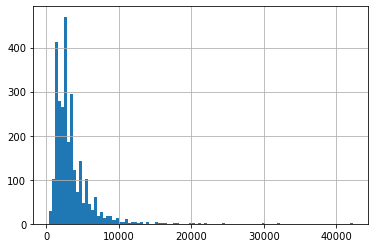

In [295]:
# посмотрим на распределение признака 'seconds'

wiki_stat_full['seconds'].hist(bins=100);

In [530]:
round(wiki_stat_full['seconds'].describe())

count     2828.0
mean      3311.0
std       2506.0
min        300.0
25%       1800.0
50%       2700.0
75%       3900.0
max      42300.0
Name: seconds, dtype: float64

In [525]:
print('среднее время участия в день (в секундах) - 95 перцентиль:', np.percentile(wiki_stat_full['seconds'], 95))
print('среднее время участия в день (в секундах) - 99 перцентиль:', np.percentile(wiki_stat_full['seconds'], 99))
print('пользователей проводят на сайте больше всего временя (в день):',
      wiki_stat_full[wiki_stat_full['seconds'] > np.percentile(wiki_stat_full['seconds'], 95)].shape[0])

среднее время участия в день (в секундах) - 95 перцентиль: 7500.0
среднее время участия в день (в секундах) - 99 перцентиль: 12000.0
пользователей проводят на сайте больше всего временя (в день): 136


В таблице wiki_stat_full хранятся данные о 2828 юзерах, из которых не имеют дополнительных прав - 2755, имеют различные доп. права - 73.

Медианное значение пребывания на сайте (в секундах в сутки) - 2700 или 45 минут. Более 7500 секунд в сутки (125 минут) на сайте проводят 136 человек.

In [531]:
# сводная таблица по пользователям - медианные значения

wiki_stat_full.groupby('groups')[['seconds', 'months', 'logs', 'editstotal', 'editsedits', 'editsarticles', 'creationspages', 
  'creationsarticles', 'textsvolume']].median().round()

,seconds,months,logs,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume
groups,,,,,,,,,
BOS,3300.0,163.0,8996.0,33489.0,24493.0,9352.0,928.0,130.0,20000000.0
BS,2700.0,181.0,7737.0,32506.0,24769.0,9715.0,1250.0,96.0,21000000.0
COS,6000.0,176.0,83136.0,187575.0,104439.0,69174.0,4989.0,72.0,67000000.0
I,2550.0,162.0,23362.0,46373.0,23012.0,10997.0,1770.0,401.0,26000000.0
IS,4500.0,151.0,21751.0,82374.0,60622.0,25336.0,1700.0,113.0,33000000.0
OS,4500.0,149.0,39846.0,88131.0,48285.0,20216.0,4059.0,373.0,48000000.0
S,4350.0,157.0,24825.0,79908.0,49674.0,26604.0,2421.0,360.0,32500000.0
no_rights,2700.0,84.0,956.0,10872.0,9332.0,6337.0,447.0,101.0,4700000.0


In [532]:
# сгруппируем пользователей до двух групп - имеющих доп. права и не имеющие

wiki_stat_full.groupby('have_rights')[['seconds', 'months', 'logs', 'editstotal', 'editsedits', 'editsarticles', 
                                       'creationspages', 'creationsarticles', 'textsvolume']].median().round()

,seconds,months,logs,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume
have_rights,,,,,,,,,
have_special_rights,3900,161,24776,74665,46387,25781,2135,277,32000000
no_rights,2700,84,956,10872,9332,6337,447,101,4700000


Сравнив две таблицы, мы видим, что: пользователи, имеющие дополнительные права больше и активнее взаимодействуют с платформой, чем пользователи, не имеющие доп. прав.

## Рассмотрим пользователей, которые проводят на сайте больше 125 минут в день:

In [539]:
# найдем пользователей, которые проводят на сайте больше всего времени в день

long_time = wiki_stat_full[wiki_stat_full['seconds'] > np.percentile(wiki_stat_full['seconds'], 95)]
long_time.head(3)

,user,groups,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,h/d,have_rights,seconds
0,MarchHare1977,no_rights,670625,658747,229189,423066,18263,79000000,11878,49,8 h 15,no_rights,29700
1,Q-bit array,COS,568443,278128,119067,62470,40,203000000,290315,103,4 h 25,have_special_rights,15900
2,Valdis72,no_rights,461773,268027,226018,36916,12295,116000000,193746,124,6 h 50,no_rights,24600


In [541]:
long_time['have_rights'].value_counts()

no_rights              131
have_special_rights      5
Name: have_rights, dtype: int64

In [544]:
long_time.groupby('have_rights')[['editstotal', 'editsedits', 'editsarticles', 'creationspages', 
                                              'creationsarticles', 'textsvolume', 'logs', 'months', 'seconds']].median().round()

,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,seconds
have_rights,,,,,,,,,
have_special_rights,254938,150162,89861,10005,40,77000000,90690,142,10200
no_rights,66865,55158,31094,2452,302,18000000,6709,49,9600


Выделим группу "безправных" и построим гистрограммы

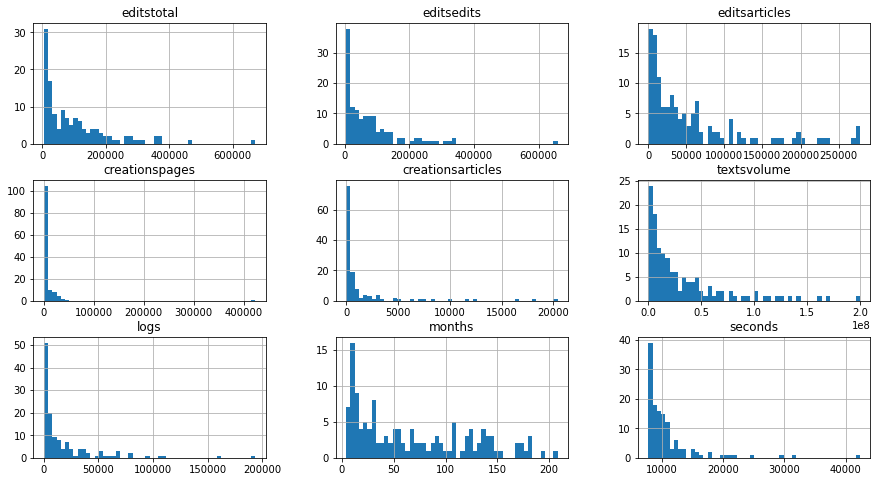

In [555]:
long_time[long_time['have_rights']=='no_rights'].hist(figsize=(15,8), grid=True, bins=50);

Большая часть значений сгруппирована около нуля + длинные жирные хвосты

## Рассмотрим рекордсменов среди рекордсменов - пользователей, которые проводят на сайте больше 332 минут в день (более пяти с половиной часов):

In [566]:
print('50 перцентиль -', np.percentile(long_time['seconds'], 50))
print('95 перцентиль -', np.percentile(long_time['seconds'], 95))
print('99 перцентиль -', np.percentile(long_time['seconds'], 99).round())

50 перцентиль - 9600.0
95 перцентиль - 19950.0
99 перцентиль - 31065.0


In [678]:
# рекордсмены по времени пребывания на википедии

long_time[long_time['seconds'] >= np.percentile(long_time['seconds'], 95)]

,user,groups,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,h/d,have_rights,seconds
0,MarchHare1977,no_rights,670625,658747,229189,423066,18263,79000000,11878,49,8 h 15,no_rights,29700
2,Valdis72,no_rights,461773,268027,226018,36916,12295,116000000,193746,124,6 h 50,no_rights,24600
52,Yaroslav Blanter,no_rights,160183,82256,39337,4137,686,58000000,77927,49,5 h 40,no_rights,20400
140,AVB,no_rights,100004,75681,43609,2299,145,36000000,24323,44,6 h 05,no_rights,21900
491,NewsBots,no_rights,36142,36133,0,7,0,2000000,9,11,8 h 50,no_rights,31800
715,Partyzan XXI,no_rights,24714,19251,9853,394,45,7000000,5463,23,5 h 50,no_rights,21000
1695,DodekBot~ruwiki,no_rights,8764,8764,8671,0,0,251000,0,11,11 h 45,no_rights,42300


В датасете 7 пользователей, которые проводят на сайте более 332 минут в день:
- они не имеют дополнительных прав (что странно),
- 5 из 7 - активные "участники русской Википедии", еще двое - боты.

## Рассмотрим пользователей, которые продуцируют больше всего информации (в байтах); сравним их с пользователями, которые проводят на сайте больше 332 минут в день:

In [676]:
print('95 перцентиль -', np.percentile(wiki_stat_full['textsvolume'], 95))
print('99 перцентиль -', np.percentile(wiki_stat_full['textsvolume'], 99).round())

95 перцентиль - 40000000.0
99 перцентиль - 83000000.0


In [679]:
amount_information = wiki_stat_full[wiki_stat_full['textsvolume'] >= np.percentile(wiki_stat_full['textsvolume'], 95)]
amount_information

,user,groups,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,h/d,have_rights,seconds
0,MarchHare1977,no_rights,670625,658747,229189,423066,18263,79000000,11878,49,8 h 15,no_rights,29700
1,Q-bit array,COS,568443,278128,119067,62470,40,203000000,290315,103,4 h 25,have_special_rights,15900
2,Valdis72,no_rights,461773,268027,226018,36916,12295,116000000,193746,124,6 h 50,no_rights,24600
3,Tempus,no_rights,372796,339636,269363,29679,922,141000000,33160,173,3 h 40,no_rights,13200
4,Simba16,no_rights,370125,333356,277881,29413,5020,67000000,36769,135,3 h 05,no_rights,11100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,Всезнайка,no_rights,14685,11494,3918,397,58,63000000,3191,135,45 m,no_rights,2700
1213,Ser-Lag,no_rights,13536,10674,8958,2399,1120,40000000,2862,122,25 m,no_rights,1500
1312,Jumpow,no_rights,12411,8896,4424,3779,1497,40000000,3515,109,20 m,no_rights,1200
1567,Stranger58,no_rights,9895,9813,8196,2166,1326,45000000,82,48,45 m,no_rights,2700


144 пользователя продуцируют больше всего информации.

In [682]:
amount_information.groupby('have_rights')[['editstotal', 'editsedits', 'editsarticles', 'creationspages', 
                                      'creationsarticles', 'textsvolume', 'logs', 'months', 'seconds']].median().round()

,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,seconds
have_rights,,,,,,,,,
have_special_rights,130017.0,87211.0,44937.0,4168.0,402.0,56000000.0,39578.0,160.0,5250.0
no_rights,113784.0,90437.0,58579.0,5945.0,2072.0,55000000.0,13224.0,140.0,6000.0


Больше информации продуцируют пользователи без дополнительных прав. Они же проводят больше времени на сайте.

# voter_full

In [302]:
voters_full = wiki_arbcom.merge(wiki_stat_full, how='left', left_on='voter', right_on='user').drop(columns=['user', 'h/d'])

In [303]:
voters_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16857 entries, 0 to 16856
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   voter              16857 non-null  object        
 1   can_vote           16857 non-null  bool          
 2   time               16857 non-null  datetime64[ns]
 3   candidate          16857 non-null  object        
 4   n                  16857 non-null  int64         
 5   vote               16857 non-null  int64         
 6   candidate_n        16857 non-null  object        
 7   groups             16632 non-null  object        
 8   editstotal         16632 non-null  float64       
 9   editsedits         16632 non-null  float64       
 10  editsarticles      16632 non-null  float64       
 11  creationspages     16632 non-null  float64       
 12  creationsarticles  16632 non-null  float64       
 13  textsvolume        16632 non-null  float64       
 14  logs  

In [304]:
voters_full.head(5)

,voter,can_vote,time,candidate,n,vote,candidate_n,groups,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,have_rights,seconds
0,X0stark69,True,2020-07-30 11:55:00,Adamant.pwn,30,1,Adamant.pwn_30,no_rights,80572.0,41020.0,32010.0,862.0,34.0,22000000.0,39552.0,70.0,no_rights,6000.0
1,Mike like0708,True,2020-07-30 09:32:00,Adamant.pwn,30,-1,Adamant.pwn_30,no_rights,7942.0,3611.0,1671.0,111.0,7.0,3400000.0,4331.0,50.0,no_rights,1500.0
2,Brateevsky,True,2020-07-30 14:43:00,Adamant.pwn,30,1,Adamant.pwn_30,no_rights,57471.0,29066.0,12884.0,2034.0,262.0,19000000.0,28405.0,149.0,no_rights,3000.0
3,Forgottenous,True,2020-07-30 08:09:00,Adamant.pwn,30,1,Adamant.pwn_30,no_rights,7652.0,5696.0,3314.0,202.0,53.0,14000000.0,1956.0,36.0,no_rights,3600.0
4,Swarrel,True,2020-08-02 14:57:00,Adamant.pwn,30,1,Adamant.pwn_30,no_rights,17835.0,9445.0,5330.0,590.0,187.0,6400000.0,8390.0,46.0,no_rights,2700.0


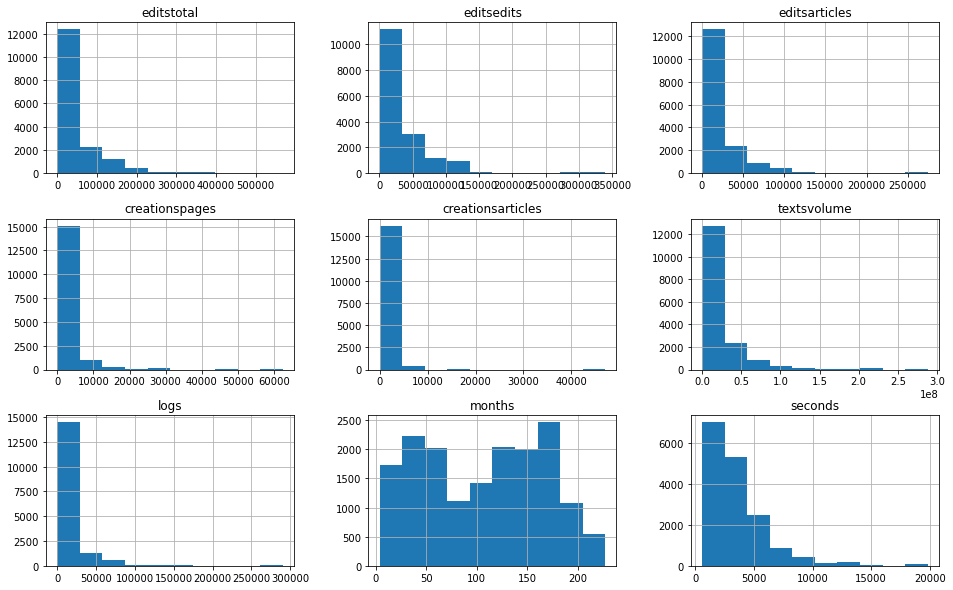

In [305]:
# рассмотрим таблицу voters_full

voters_full[['editstotal', 'editsedits', 'editsarticles', 'creationspages',
             'creationsarticles', 'textsvolume', 'logs', 'months', 'seconds']] \
            .hist(figsize=(16,10), grid=True);

Здесь мы также находим подтверждение своих предположений из предыдущего шага: больше всего пользователей, не имеющих дополнительных прав, значения их признаков невелико - большая часть графиков имеет "горб" около нуля.

Из общей картины выбивается только переменная "month".

Согласно условиям, "Побеждают кандидаты, которые набирают ⅔ голосов “за”. Выделим победивших

In [517]:
votes_per_candidate = pd.crosstab(voters_full['candidate_n'], voters_full['vote'], values=voters_full['vote'], 
                                 aggfunc='count').reset_index()

votes_per_candidate.rename(columns={-1: 'vote: -1', 1: 'vote: 1'}, inplace=True)

votes_per_candidate['cut-off'] = round(votes_per_candidate[['vote: -1', 'vote: 1']].sum(axis=1) * 2 / 3)

votes_per_candidate['winner'] = votes_per_candidate['vote: 1'] > votes_per_candidate['cut-off']

votes_per_candidate.head(5)

vote,candidate_n,vote: -1,vote: 1,cut-off,winner
0,Abiyoyo_32,89,87,117.0,False
1,Adamant.pwn_30,45,103,99.0,True
2,Adamant.pwn_31,45,103,99.0,True
3,Adamant.pwn_32,71,92,109.0,False
4,Adamant.pwn_35,62,134,131.0,True


In [307]:
# добавим отметку True тем кандидатам, которые победили в выборах

voters_full = voters_full.merge(votes_per_candidate.drop(columns=['vote: -1', 'vote: 1']), how='left', on='candidate_n')

In [308]:
# отсортируем пользователей
# оставим тех, чей голос засчитался и кто голосовал за победителей

can_vote_for_winner = voters_full.loc[((voters_full['can_vote'] == True) & (voters_full['winner'] == True) & 
                                       (voters_full['vote'] == 1))]

In [309]:
# посчитаем сумму голосов с накоплением

votes_cumsum = pd.DataFrame(can_vote_for_winner.groupby(['candidate_n', 'time'])['vote']
                            .sum().groupby(level=0).cumsum()).reset_index()

In [310]:
# выделим победителей в отдельный список для удобства

winners = votes_cumsum['candidate_n'].unique().tolist()

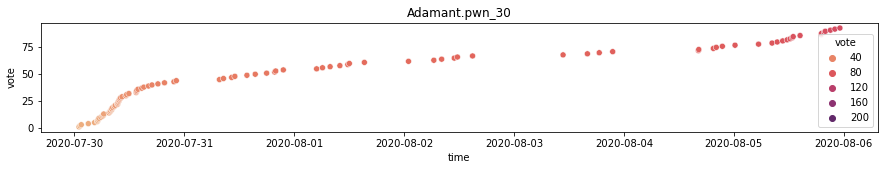

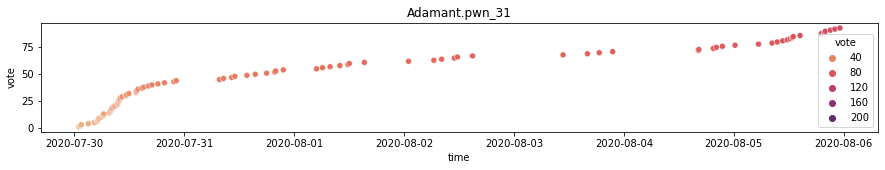

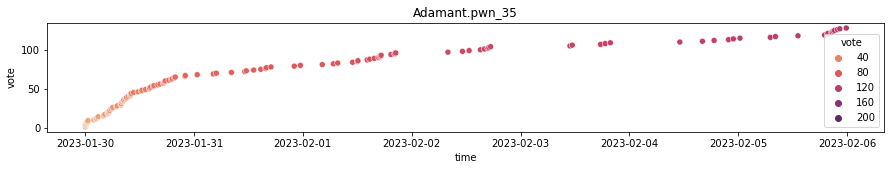

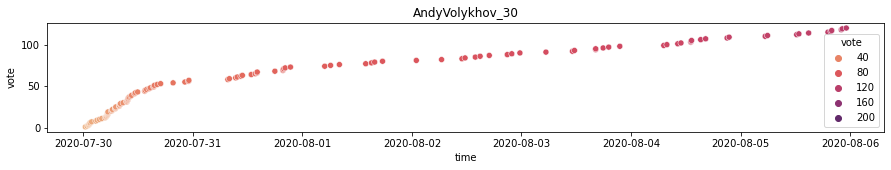

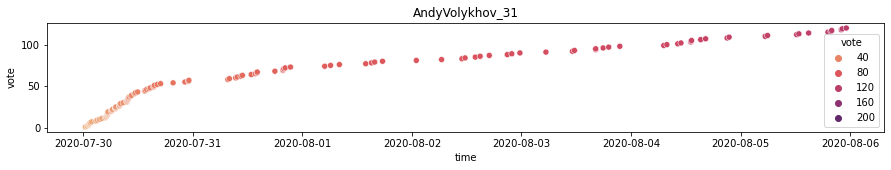

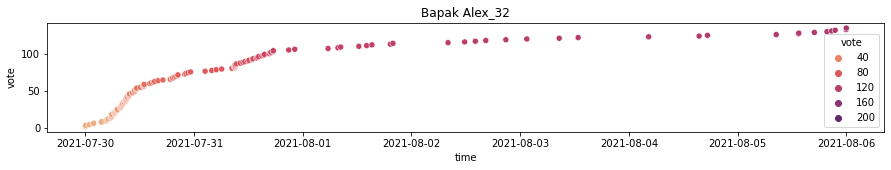

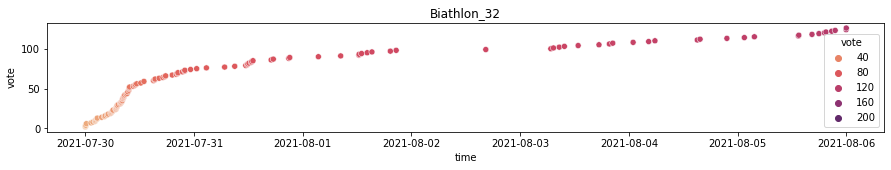

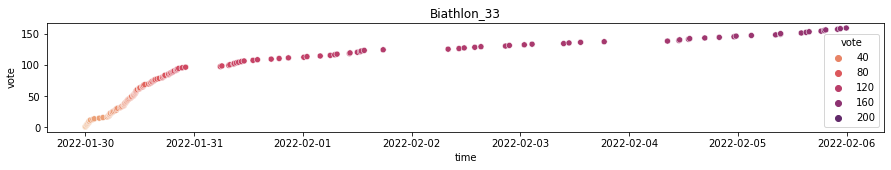

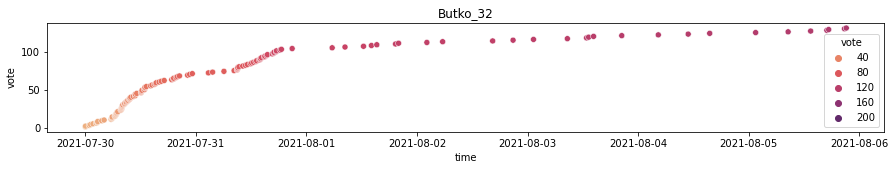

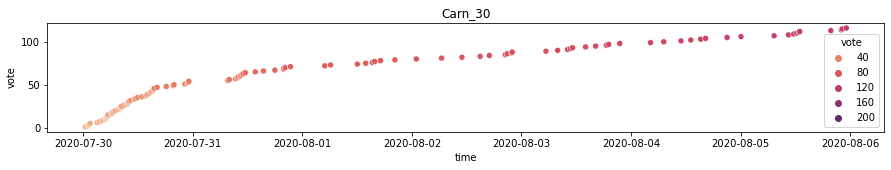

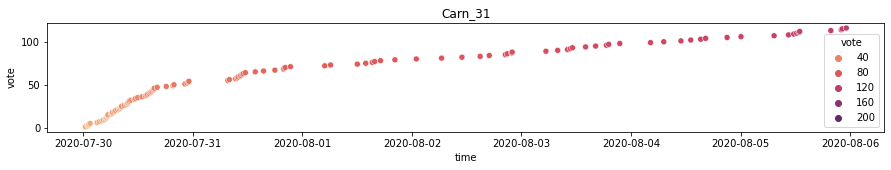

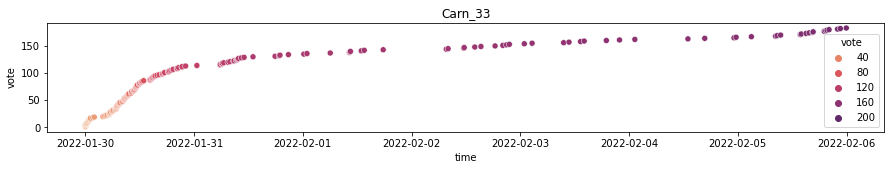

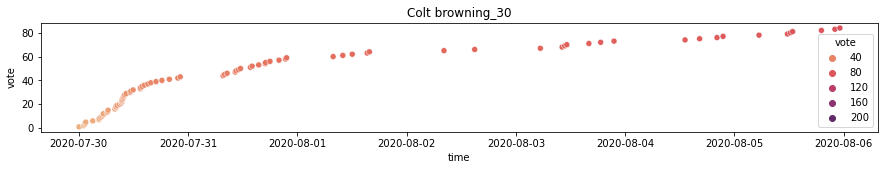

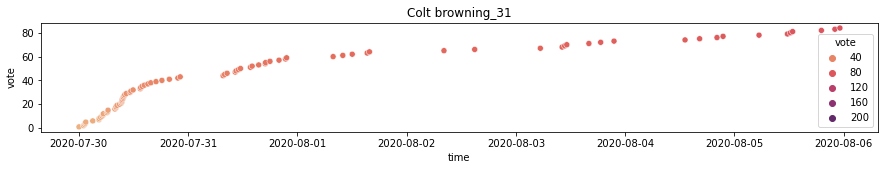

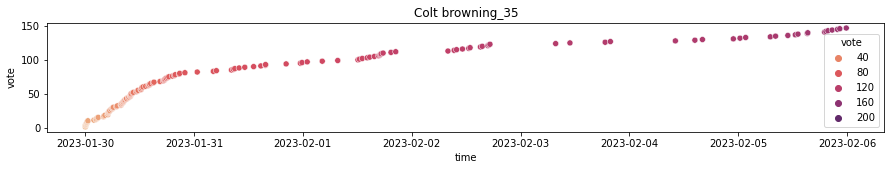

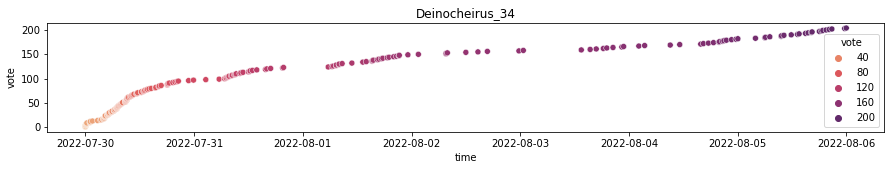

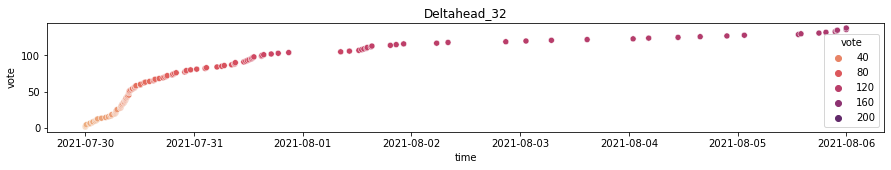

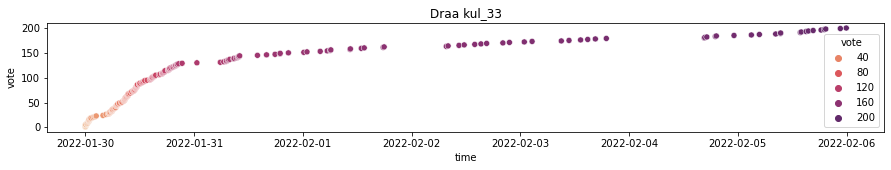

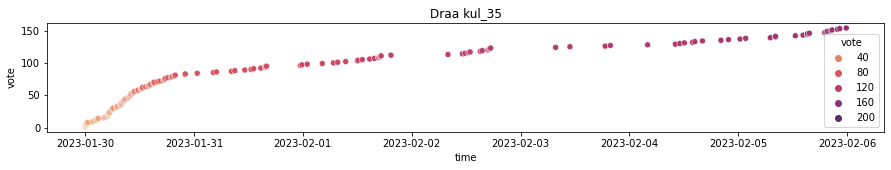

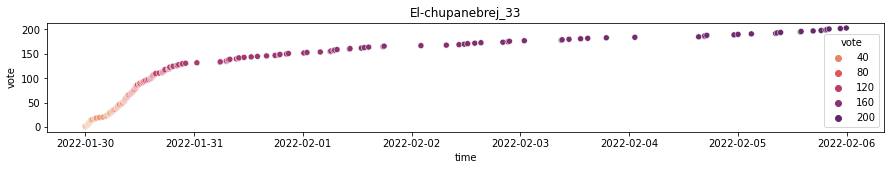

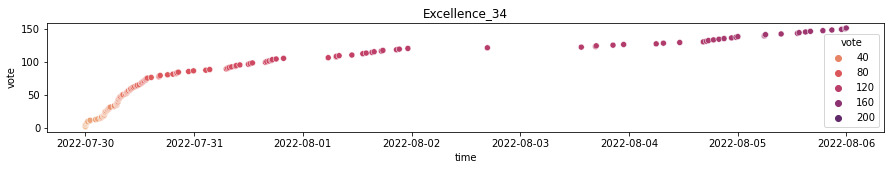

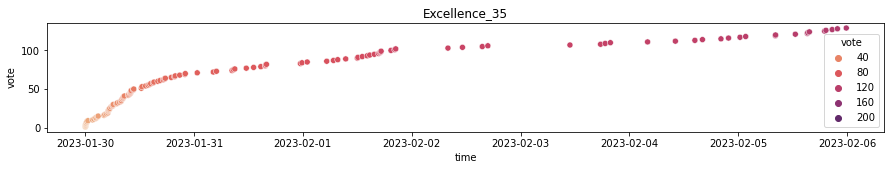

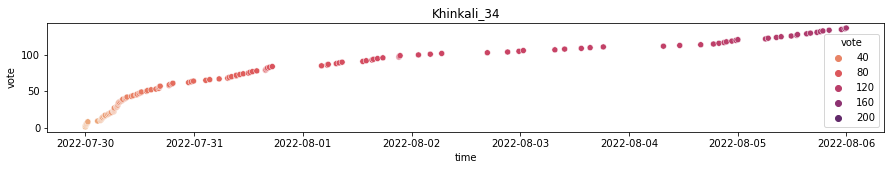

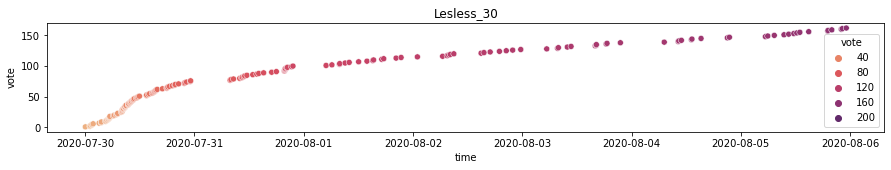

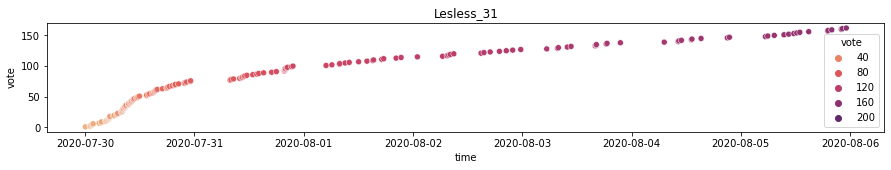

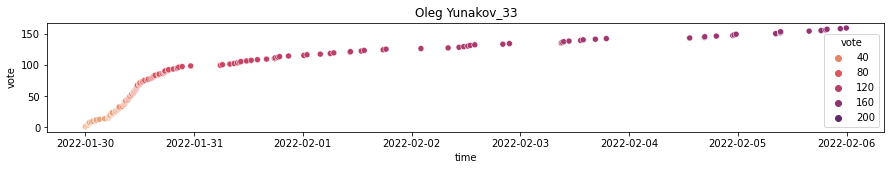

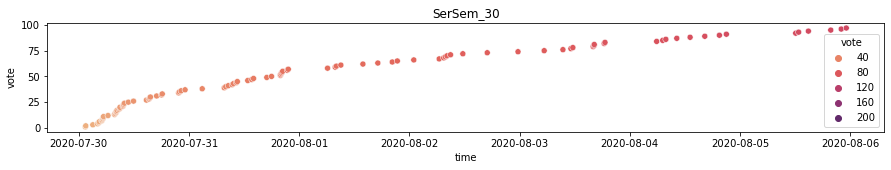

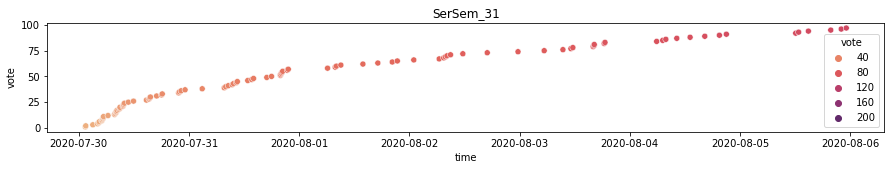

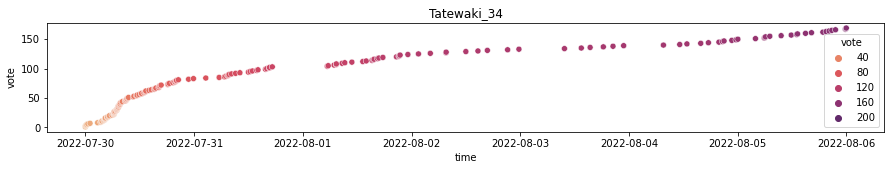

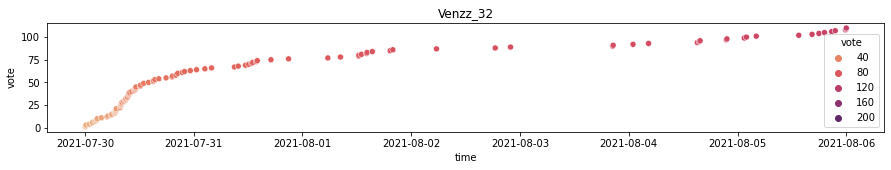

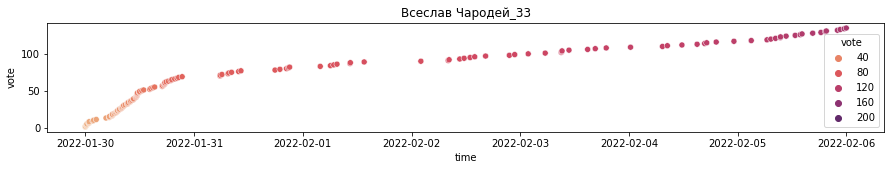

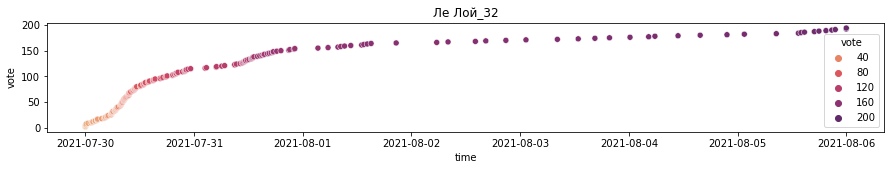

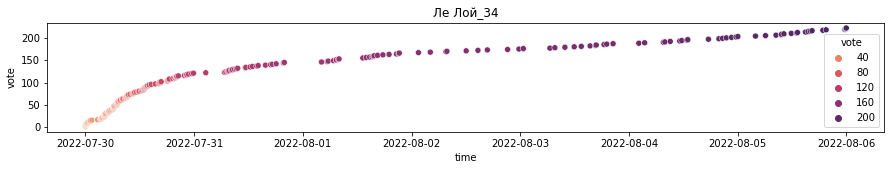

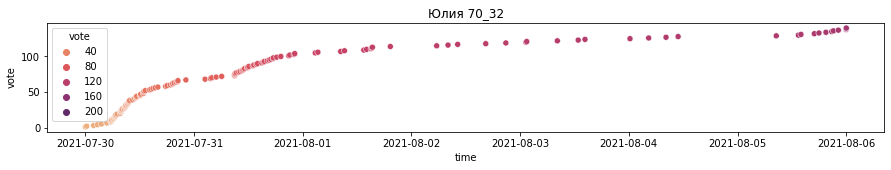

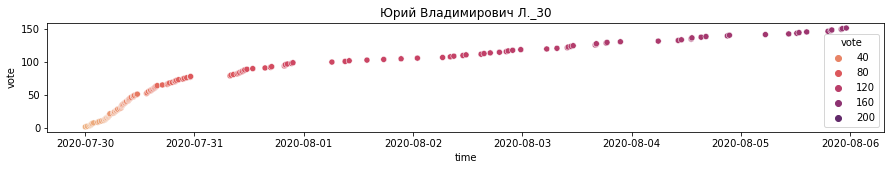

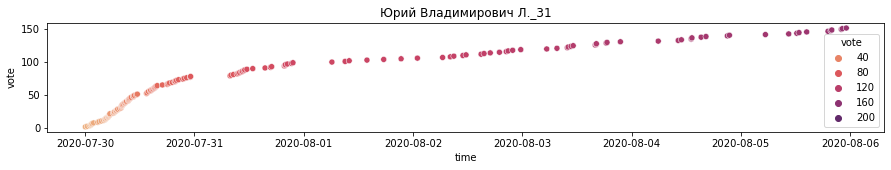

In [311]:
for winner in winners:
    plt.subplots(figsize=(15, 2))
    plt.title(winner)
    sns.scatterplot(x = votes_cumsum[votes_cumsum['candidate_n'] == winner]['time'], 
                    y = votes_cumsum[votes_cumsum['candidate_n'] == winner]['vote'], 
                    hue=votes_cumsum['vote'], palette="flare")
    
    plt.show()

> В самом начале я заметила, что дата и время 30 и 31 выборов совпадают: по условиям, выборы проходят раз в полгода. Возможно, это ошибка и данные задублированы. Это подтверждают графики победителей 30 и 31 выборов - точки на графике расположены идентично.

Голосование активнее идет в первые дни после старта.

# Изучим поведение кандидатов-победителей

In [329]:
winners_withoutn = voters_full[voters_full['winner']==True]['candidate'].unique()

In [337]:
candidates = voters_full.loc[voters_full["voter"].isin(winners_withoutn)]

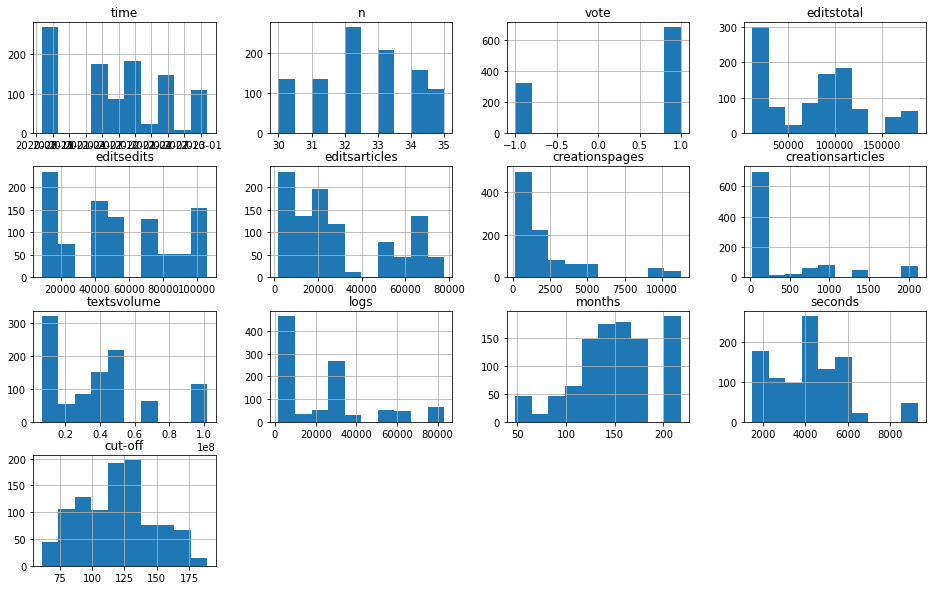

In [340]:
candidates.hist(figsize=(16,10), grid=True);

In [569]:
# Сохраним медианные значений переменных
# создадим сводную таблицу по кандидатам

candidates_median = dict(candidates.describe().round().iloc[5])

candidates_pivot = pd.DataFrame(candidates.groupby('voter')[['editstotal', 'editsedits', 'editsarticles', 'creationspages', 
                                              'creationsarticles', 'textsvolume', 'logs', 'months', 'seconds']].median())

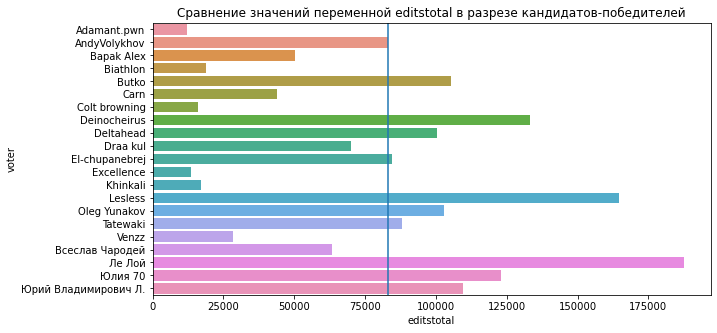

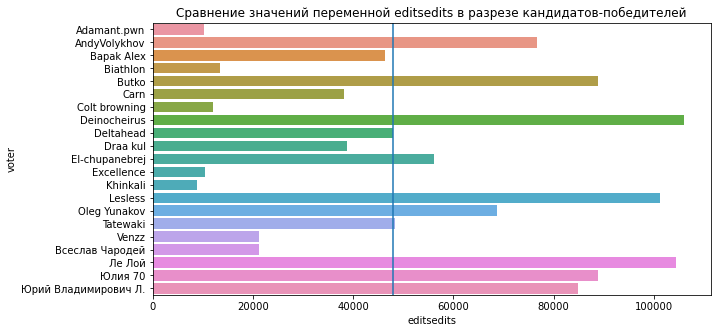

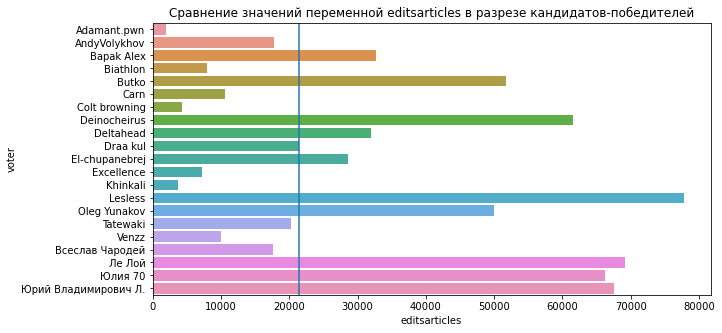

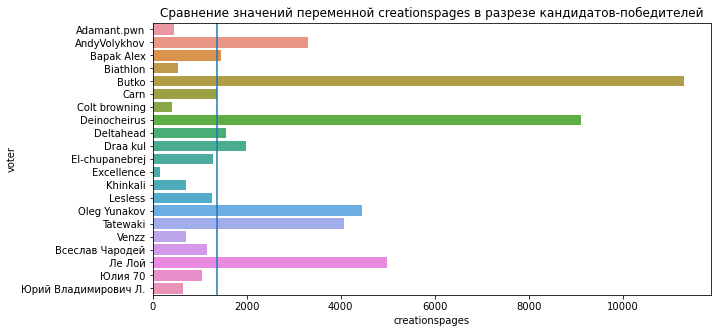

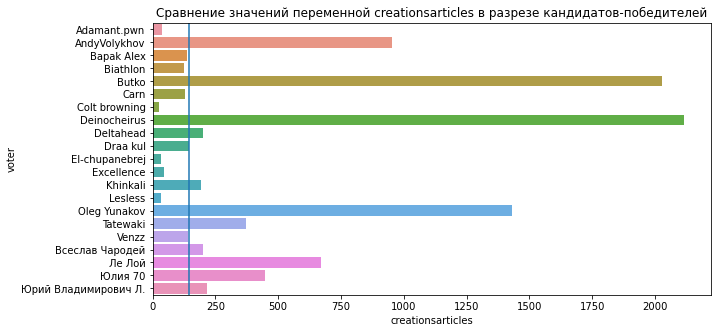

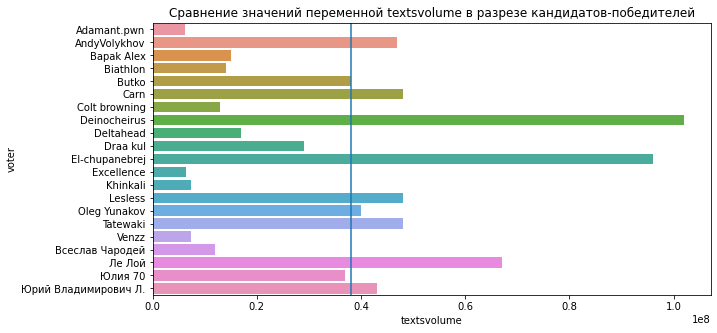

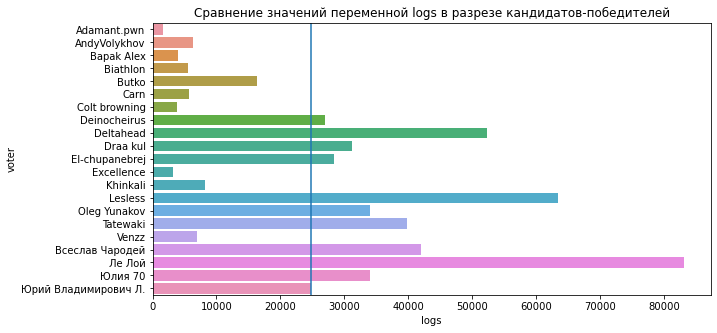

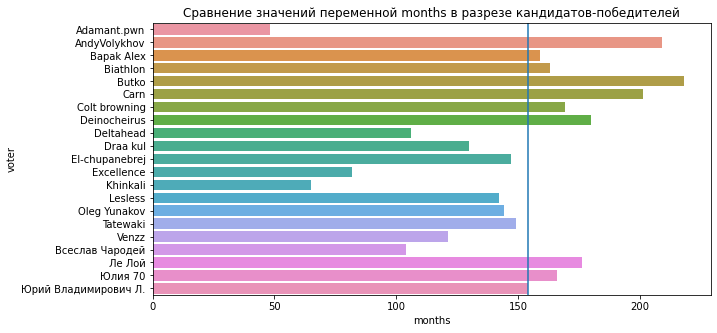

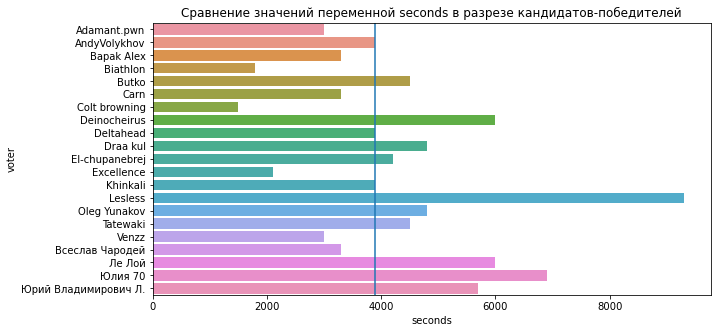

In [570]:
# визуализируем победителей
# сделаем вертикальную отсечку на медианном значении

for column_pivot in candidates_pivot.columns:
    plt.subplots(figsize=(10, 5))
    for key, value in candidates_median.items():
        if column_pivot == key:
            plt.axvline(value)
    sns.barplot(y=candidates_pivot.index, x=candidates_pivot[column_pivot])
    plt.title(f'Сравнение значений переменной {column_pivot} в разрезе кандидатов-победителей')
    plt.show()

Adamant.pwn и Colt browning побеждали трижды (30, 31, 35).

Дважды побеждали:
- AndyVolykhov (30, 31)

- Biathlon (32, 33)

- Draa kul (33, 35)

- Excellence (34, 35)

- Lesless (30, 31)

- SerSem (30, 31)

- Ле Лой (32, 34)

- Юрий Владимирович Л. (30, 31)

Adamant.pwn значительно отличается от остальных кандидатов: чаще всего у него меньше всего правок, меньше созданных странниц и объема написанного текста, он меньше всего времени (по сравнению с другими кандидатами) провел на википедии. Так же, он проводит на сайте времени меньше медианного значения.

Другой победитель, Colt browning, так же остает от остальных в количестве созданного и отредактированного материала, но является долгожителем на сайте.

Рассмотрим их подробнее.

In [511]:
# сделаем срез по голосующим, оставим информацию только о Colt browning и Adamant.pwn

adamant_colt = voters_full.copy()
adamant_colt = adamant_colt.query("voter in ('Adamant.pwn', 'Colt browning')")

In [547]:
# посмотрим общую информацию

print('сводная информация:')

print('есть данные о голосовании (Adamant.pwn):  ', adamant_colt[adamant_colt['voter']=='Adamant.pwn']['time'].min(), '-', \
                                                  adamant_colt[adamant_colt['voter']=='Adamant.pwn']['time'].max())

print('есть данные о голосовании (Colt browning):', adamant_colt[adamant_colt['voter']=='Colt browning']['time'].min(), '-', \
                                                  adamant_colt[adamant_colt['voter']=='Colt browning']['time'].max())

print('группа (Adamant.pwn):', adamant_colt[adamant_colt['voter']=='Adamant.pwn']['groups'].unique())
print('группа (Colt browning):', adamant_colt[adamant_colt['voter']=='Colt browning']['groups'].unique())


pd.DataFrame(adamant_colt.groupby('voter')[['editstotal', 'editsedits', 'editsarticles', 'creationspages', 
                                              'creationsarticles', 'textsvolume', 'logs', 'months', 'seconds']].median())

сводная информация:
есть данные о голосовании (Adamant.pwn):   2020-07-30 00:02:00 - 2023-02-05 08:44:00
есть данные о голосовании (Colt browning): 2020-07-30 16:12:00 - 2023-01-31 15:59:00
группа (Adamant.pwn): ['S']
группа (Colt browning): ['BS']


,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,seconds
voter,,,,,,,,,
Adamant.pwn,11976.0,10295.0,1927.0,445.0,38.0,6200000.0,1681.0,48.0,3000.0
Colt browning,15946.0,12145.0,4248.0,423.0,25.0,13000000.0,3801.0,169.0,1500.0


Различия в топовых кандидатах:
- адамант меньше редактирует, больше создает страниц, но с меньшим наполнением, зарегистрировался недавно, проводит на сайте больше времени в секундах в сутки,
- кольт больше редактируем, создает меньше, но качественнее, больше записей в логах, дольше зарегестрирован.

Большое количество записей в логах говорит о том, что он чаще модерирует (может быть, за это его и выбирают?).
Как побеждает Адамант - загадка.

In [509]:
# сводная таблица по голосам

pd.crosstab(adamant_colt['candidate'], [adamant_colt['voter'], adamant_colt['vote']], 
            values=adamant_colt['vote'], aggfunc='count', margins=True).fillna(0)

voter                Adamant.pwn       Colt browning       All
vote                          -1     1            -1     1    
candidate                                                     
Abiyoyo                      0.0   0.0           0.0   1.0   1
Adamant.pwn                  0.0   0.0           0.0   4.0   4
Ailbeve                      1.0   0.0           0.0   0.0   1
Alexander Roumega            2.0   0.0           0.0   0.0   2
AndreiK                      2.0   0.0           1.0   0.0   3
AndyHomba                    1.0   0.0           0.0   0.0   1
AndyVolykhov                 0.0   2.0           0.0   2.0   4
Arsenal.UC                   1.0   0.0           0.0   0.0   1
Biathlon                     1.0   1.0           1.0   1.0   4
Butko                        1.0   0.0           0.0   0.0   1
Carn                         1.0   3.0           0.0   5.0   9
Colt browning                0.0   3.0           0.0   1.0   4
Deinocheirus                 0.0   0.0           0.0   1.0   1
Deltahead                    0.0   1.0           0.0   1.0   2
Dimetr                       1.0   0.0           1.0   0.0   2
Draa kul                     0.0   1.0           0.0   2.0   3
El-chupanebrej               0.0   0.0           0.0   1.0   1
Engelberthumperdink          1.0   0.0           1.0   0.0   2
Excellence                   0.0   0.0           0.0   2.0   2
Glavkom NN                   1.0   0.0           0.0   0.0   1
Grig siren                   1.0   0.0           0.0   0.0   1
Helgo13                      0.0   0.0           0.0   1.0   1
La loi et la justice         1.0   0.0           1.0   0.0   2
Lesless                      0.0   2.0           0.0   0.0   2
Morihei Tsunemori            1.0   0.0           0.0   0.0   1
Niklitov                     1.0   0.0           1.0   0.0   2
Oleg Yunakov                 0.0   1.0           0.0   2.0   3
Sas1975kr                    0.0   0.0           0.0   1.0   1
Sir Shurf                    1.0   0.0           0.0   1.0   2
Uchastnik1                   1.0   0.0           0.0   0.0   1
Venzz                        0.0   3.0           0.0   2.0   5
Wanderer777                  1.0   0.0           1.0   0.0   2
Всеслав Чародей              0.0   2.0           0.0   1.0   3
Гоголь М                     1.0   0.0           0.0   0.0   1
Кронас                       0.0   1.0           0.0   0.0   1
Ле Лой                       0.0   2.0           0.0   2.0   4
Юрий Владимирович Л.         0.0   2.0           0.0   0.0   2
All                         21.0  24.0           7.0  31.0  83

Голоса "за" и "против":
- у Адаманта - примерно поровну,
- Кольт - чаще ставит "за", чем "против.

Кольт часто голосует за одних и тех же на нескольких выборах (адамант в числе его любимчиков - 4 голоса за на разных выборах).

# Кластеризация (попытка)

В исходном датасете voters_full было 16857 строк, в некоторых столбцах есть пропущенные значения, удалим их.

In [579]:
voter_cluster = voters_full.copy()
voter_cluster.dropna(inplace=True)

In [583]:
# проверка:

# voter_cluster.info()

После удаления в датасет "voter_cluster" вошло 16632 строк.

In [649]:
X = voter_cluster.drop(columns=['time', 'voter', 'can_vote', 'candidate', 'n', 'candidate_n', 'have_rights',
                                'cut-off', 'winner', 'vote', 'groups'])

In [640]:
#X = pd.get_dummies(X, drop_first=True)

In [651]:
scaler = StandardScaler() 

X_sc = scaler.fit_transform(X)

In [653]:
%%time

linked = linkage(X_sc, method = 'ward') 

Wall time: 11.7 s


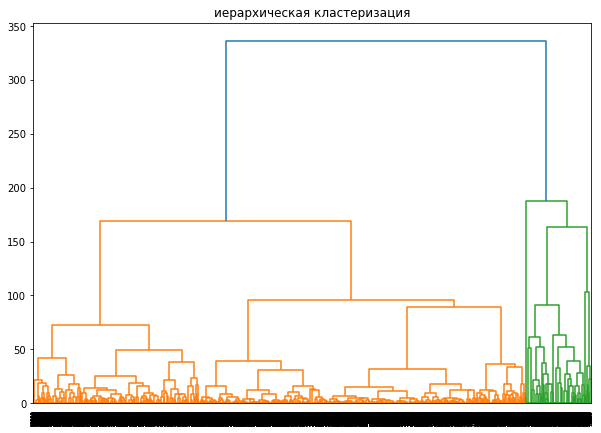

Wall time: 18min 50s


In [659]:
%%time

plt.figure(figsize=(10, 7))  
dendrogram(linked, orientation='top')
plt.title('иерархическая кластеризация')
plt.show() 

In [672]:
km = KMeans(n_clusters=5, random_state=0) 

In [673]:
labels = km.fit_predict(X_sc) 

In [674]:
X['cluster_label'] = labels

In [675]:
X.groupby('cluster_label').median().round()

,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,seconds
cluster_label,,,,,,,,,
0,36594.0,29412.0,14743.0,1206.0,166.0,17000000.0,5538.0,150.0,2700.0
1,284611.0,229484.0,123083.0,10005.0,522.0,101000000.0,90690.0,124.0,13200.0
2,6827.0,4980.0,2559.0,127.0,29.0,2700000.0,601.0,43.0,2400.0
3,130574.0,84124.0,79174.0,49111.0,47062.0,288000000.0,46450.0,114.0,7200.0
4,123401.0,95629.0,61578.0,4989.0,501.0,53000000.0,28313.0,153.0,6000.0
